In [1]:
import geemap
import ee 
import os

# Set parameters

In [2]:
# years between 2000 and 2018 inclusive available for both layers
startyear = 2000 
# years between 2000 and 2018 inclusive available for both layers 
endyear = 2018 
# ISO 3-letter country code
countryCode = 'MEX'
# Admin Level 1 name - required for geoB state calculations only, and chart titles
AOI = 'Yucatán'

# Get Map

In [3]:
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

# Get population data

In [4]:
pop = ee.ImageCollection("WorldPop/GP/100m/pop")

popviz = {
  'bands': ['population'],
  'min': 0.0,
  'max': 100.0,
  'palette': ['24126c', '1fff4f', 'd4ff50']
}

Map.addLayer(pop, popviz, 'Population')

# Get impervious area

In [5]:
imperv = ee.Image("Tsinghua/FROM-GLC/GAIA/v10")

startyearindex = 2019 - startyear
endyearindex = 2019 - endyear


impervviz = {
  'min': 0.0,
  'max': 34.0,
  'palette': [
    "014352","1A492C","071EC4","B5CA36","729EAC","8EA5DE",
    "818991","62A3C3","CCF4FE","74F0B9","32BC55","C72144",
    "56613B","C14683","C31C25","5F6253","11BF85","A61B26",
    "99FBC5","188AAA","C2D7F1","B7D9D8","856F96","109C6B",
    "2DE3F4","9A777D","151796","C033D8","510037","640C21",
    "31A191","223AB0","B692AC","2DE3F4",
  ]
}

Map.addLayer(imperv, impervviz, 'Impervious change year')


In [6]:
# Calculate and display start and end year impervious maps

impervStart = imperv.updateMask(imperv.gte(startyearindex)).multiply(ee.Image.pixelArea().reproject('EPSG:4326').multiply(0.000001)).rename('ImpervStart')
impervEnd = imperv.updateMask(imperv.gte(endyearindex)).multiply(ee.Image.pixelArea().reproject('EPSG:4326').multiply(0.000001)).rename('ImpervEnd')

# Add layers
Map.addLayer(impervStart, impervviz, "Impervious Area (km2) in "+str(startyear)+"",False)
Map.addLayer(impervEnd, impervviz, "Impervious Area (km2) in "+str(endyear)+"",False)

# center viz

In [7]:
# get geoboundaries dataset
geoBadm2 = ee.FeatureCollection('projects/wri-datalab/geoBoundaries/geoBoundariesCGAZ_ADM2')

munis = geoBadm2.filter(ee.Filter.eq('ADM1_sha_1', AOI))
muniName = 'shapeName'

Map.centerObject(munis,9)

# filter pop

In [8]:
# pop start year
popStart = pop.filter(ee.Filter.bounds(munis)).filterMetadata('year', 'equals', startyear).filterMetadata('country', 'equals', countryCode)

#print(popStart)
Map.addLayer(popStart, popviz, 'Population '+str(startyear)+'',False,0.5)
mergedpopStart = popStart.toBands().rename('PopStart')

In [9]:
# pop end year
popEnd = pop.filter(ee.Filter.bounds(munis)).filterMetadata('year', 'equals', endyear).filterMetadata('country', 'equals', countryCode)

#print(popEnd)
Map.addLayer(popEnd, popviz, 'Population '+str(endyear)+'',False,0.5)
mergedpopEnd = popEnd.toBands().rename('PopEnd')

In [10]:
 # Combine 2 pop and 2 imperv datasets into one image with 4 bands
stackedImage = mergedpopStart.addBands(mergedpopEnd).addBands(impervStart).addBands(impervEnd)

In [11]:
reduced = stackedImage.reduceRegions(**{
    'collection': munis,
    'reducer': ee.Reducer.sum()
})

# Export results

In [12]:
out_dir = os.getcwd()

In [13]:
out_shp = os.path.join(out_dir, "reduced.geojson")
geemap.ee_export_vector(reduced, out_shp, verbose=True)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Saif.Shabou\OneDrive - World Resources Institute\Documents\Python Scripts\UrbanShift\Urban Growth\reduced.geojson


# Annual rate of population change
 Computes annual rate of population change = (EndPop - StartPop / (EndYear - StartYear)) / StartPop * 100

In [14]:
def computePopRate(feature):
    PEnd = ee.Number(feature.get('PopEnd'))
    PStart = ee.Number(feature.get('PopStart'))
    EndY = ee.Number(endyear)
    StartY = ee.Number(startyear)
    return feature.set({'PopRate': (((PEnd.divide(PStart)).log()).divide(EndY.subtract(StartY))).multiply(100)})

# generate a new property for all features
reduced = reduced.map(computePopRate)

In [15]:
#show new property values
#print(reduced.aggregate_array('PopRate'))

In [16]:
# Export results
out_shp = os.path.join(out_dir, "reduced_PopRate.geojson")
geemap.ee_export_vector(reduced, out_shp, verbose=True)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Saif.Shabou\OneDrive - World Resources Institute\Documents\Python Scripts\UrbanShift\Urban Growth\reduced_PopRate.geojson


# Annual rate of impervious area change
Computes annual rate of impervious area change = (EndImperv - StartImperv / (EndYear - StartYear)) / StartImperv *100

In [17]:
def computeImpervRate(feature):
    IEnd = ee.Number(feature.get('ImpervEnd'))
    IStart = ee.Number(feature.get('ImpervStart'))
    EndY = ee.Number(endyear)
    StartY = ee.Number(startyear)
    return feature.set({'ImpervRate': (((IEnd.divide(IStart)).log()).divide(EndY.subtract(StartY))).multiply(100)})

# generate a new property for all features
reduced = reduced.map(computeImpervRate)

In [18]:
# show new property values
# print('ImpervRate', reduced.aggregate_array('ImpervRate'))

In [19]:
# Export results
out_shp = os.path.join(out_dir, "reduced_ImpervRate.geojson")
geemap.ee_export_vector(reduced, out_shp, verbose=True)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Saif.Shabou\OneDrive - World Resources Institute\Documents\Python Scripts\UrbanShift\Urban Growth\reduced_ImpervRate.geojson


# Computes SDG Indicator 11.3.1: "Ratio of land consumption rate to population growth rate" 
Ratio = ImpervRate / PopRate

In [20]:
def computeGrowthRatio(feature):
    Irate = ee.Number(feature.get('ImpervRate'))
    Prate = ee.Number(feature.get('PopRate'))
    return feature.set({ 'GrowthRatio': (Irate.divide(Prate)).abs()})

# generate a new property for all features
reduced = reduced.map(computeGrowthRatio)

In [21]:
# Export results
out_shp = os.path.join(out_dir, "reduced_GrowthRate.geojson")
geemap.ee_export_vector(reduced, out_shp, verbose=True)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Saif.Shabou\OneDrive - World Resources Institute\Documents\Python Scripts\UrbanShift\Urban Growth\reduced_GrowthRate.geojson


## Visualize two change and 1 ratio calculations 
### Population annual rate of change

In [22]:
fillspalette = ['0000FF', '00FF00', 'FF0000']
edgepalette = ['000000']
empty = ee.Image().byte()

In [23]:
Pfills = empty.paint(**{
  'featureCollection': reduced,
  'color': 'PopRate'
  })

In [24]:
Map.addLayer(Pfills, {'palette': fillspalette, 'min': -5, 'max': 5}, 'Population annual rate of change % ('+str(startyear)+'-'+str(endyear)+')', True, 0.5)


### Impervious area annual rate of change

In [25]:
empty = ee.Image().byte()
Ifills = empty.paint(**{
  'featureCollection': reduced,
  'color': 'ImpervRate'
  })

Map.addLayer(Ifills, {'palette': fillspalette, 'min': -5, 'max': 5}, 'Impervious annual rate of change % ('+str(startyear)+'-'+str(endyear)+')', True, 0.5)


### Ratio of land consumption and population growth rates

In [26]:
empty = ee.Image().byte()
Gfills = empty.paint(**{
  'featureCollection': reduced,
  'color': 'GrowthRatio'
  })

Map.addLayer(Gfills, {'palette': fillspalette, 'min': -5, 'max': 5}, 'Ratio of land consumption and population growth rates ('+str(startyear)+'-'+str(endyear)+')', True, 0.5)


### export results

In [27]:
# Export results
out_shp = os.path.join(out_dir, "reduced_Final.geojson")
geemap.ee_export_vector(reduced, out_shp, verbose=True)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Saif.Shabou\OneDrive - World Resources Institute\Documents\Python Scripts\UrbanShift\Urban Growth\reduced_Final.geojson


# chart to compare 'PopRate' and 'ImpervRate'

In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [43]:
reduced_Final = gpd.read_file('reduced_Final.geojson')
# print(reduced_Final.head())

In [44]:
reduced_Final_df = pd.DataFrame(reduced_Final)

<AxesSubplot:title={'center':'Urban Area and population change'}, xlabel='PopRate', ylabel='ImpervRate'>

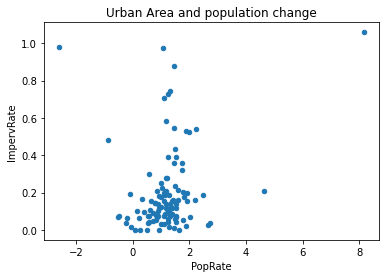

In [45]:
reduced_Final_df.plot.scatter(x="PopRate", y="ImpervRate",title= "Urban Area and population change")